In [1]:
#!which pip
!where pip

C:\Users\mizun\anaconda3\envs\py311Omaezaki\Scripts\pip.exe


In [2]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import japanize_matplotlib
from shapely.geometry import Point, shape, Polygon, MultiPolygon
import json
import folium
from folium import Choropleth
from folium.plugins import HeatMap
import os
from glob import glob
from matplotlib import cm
from matplotlib.colors import to_hex
import osmnx as ox
import networkx as nx


In [3]:
#都道府県コード
pricode = 22

In [4]:
# GeoJSONファイルを読み込み
mesh_path = f"./../data/500mメッシュ別将来推計人口データ（R6国政局推計）/500m_mesh_2024_{pricode}.geojson"
gdf = gpd.read_file(mesh_path)  # ←ファイル名を適宜変更


# 元が EPSG:6668（JGD2011）の場合、可視化や汎用処理の都合でWGS84に変換
if gdf.crs is None:
    gdf.set_crs(epsg=6668, inplace=True)  # 念のため
gdf = gdf.to_crs(epsg=4326)

# 代表点を列として追加（geometryは変えない）
gdf["reppt"] = gdf.representative_point()
gdf["lon"] = gdf["reppt"].x
gdf["lat"] = gdf["reppt"].y

# 可視化用にPointのGDFが必要なら：
mesh_points = gdf.set_geometry("reppt", drop=False)

# データ確認CSV（属性＋代表点）
gdf.drop(columns="geometry").to_csv(f"../results/{pricode}_data_rate.csv", index=False, encoding="utf-8-sig")
print("ベースCSVを保存しました")

C:\Users\mizun\AppData\Local\Temp\ipykernel_1080\3618342786.py:17: FutureWarning: The `drop` keyword argument is deprecated and in future the only supported behaviour will match drop=False. To silence this warning and adopt the future behaviour, stop providing `drop` as a keyword to `set_geometry`. To replicate the `drop=True` behaviour you should update your code to
`geo_col_name = gdf.active_geometry_name; gdf.set_geometry(new_geo_col).drop(columns=geo_col_name).rename_geometry(geo_col_name)`.
  mesh_points = gdf.set_geometry("reppt", drop=False)


ベースCSVを保存しました


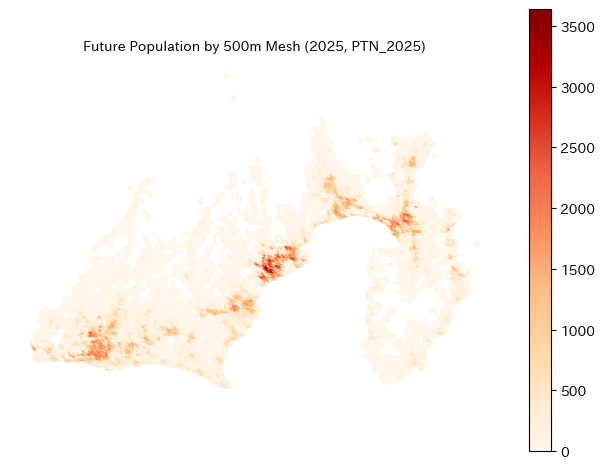

C:\Users\mizun\AppData\Local\Temp\ipykernel_1080\3872467130.py:14: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  center = gdf["reppt"].unary_union.centroid


In [5]:
# %%
# 2) 2025年総人口（PTN_2025）を静的図でクイック確認（メッシュは Point 表示）
fig, ax = plt.subplots()
mesh_points.plot(column="PTN_2025", cmap="OrRd", markersize=10, legend=True, ax=ax)
ax.set_title("Future Population by 500m Mesh (2025, PTN_2025)", fontsize=10)
ax.axis("off")
plt.tight_layout()
plt.savefig(f"../results/{pricode}_500mメッシュ別将来人口（2025年・PTN_2025）.png", dpi=200)
plt.show()

# %%
# 3) foliumヒートマップ（代表点×人口）
# 中心は代表点のunary_unionから
center = gdf["reppt"].unary_union.centroid
heat_data = [
    [pt.y, pt.x, pop]
    for pt, pop in zip(gdf["reppt"], gdf["PTN_2025"])
    if pd.notna(pop) and pop > 0
]
m = folium.Map(location=[center.y, center.x], zoom_start=10, tiles="cartodbpositron")
HeatMap(heat_data, radius=15, blur=20, max_zoom=13).add_to(m)
m.save(f"../results/{pricode}_500mヒートマップ_2025.html")

## 道路カウント

In [6]:
# GeoJSONの読み込み
with open(mesh_path, "r", encoding="utf-8") as f:
    geojson_data = json.load(f)

In [7]:
# ox.settings.use_cache = True  # 同じ範囲の再取得を速く
# ox.settings.log_console = False

# # 1) 対象の都道府県（静岡 + 隣接県）
# prefectures = [
#     "Shizuoka, Japan",
# ]

# # 2) 県ポリゴンを取得してユニオン（結合）
# gdf = ox.geocoder.geocode_to_gdf(prefectures)
# union_poly = gdf.union_all()  # MultiPolygon/Polygon

# # 3) 道路ネットワークを取得（車道中心。歩道等も含めるなら 'all' などに変更）
# G = ox.graph_from_polygon(union_poly, network_type="drive", simplify=True)

# # GraphML 形式（推奨：QGISやGephiでも読める）
# ox.save_graphml(G, filepath="../data/shizuoka_drive.graphml")

# 後で読むとき
G = ox.load_graphml("../data/shizuoka_drive.graphml")

In [8]:
results = []

# --- 1) グラフを投影 ---
# 既に G がある前提（例: G = ox.load_graphml("...")）
Gp = ox.project_graph(G)                 # 投影（UTM 等）
target_crs = Gp.graph["crs"]

# --- 3) 無向化（往復重複をまとめる：MultiGraph を使用）---
Gu = nx.MultiGraph(Gp)

# --- 4) GeoDataFrame 化 ---
_, gdf_edges = ox.graph_to_gdfs(Gu)

for feature in geojson_data["features"]:
    mesh_id = feature["properties"]["MESH_ID"]
    coords = feature["geometry"]["coordinates"][0]  # [[lon, lat], ...]

    # ポリゴンを作成
    poly_wgs84 = Polygon(coords)
    gdf_poly = gpd.GeoDataFrame(geometry=[poly_wgs84], crs="EPSG:4326")
    gdf_poly_proj = gdf_poly.to_crs(target_crs)  # グラフと同じ座標系へ変換
    poly_proj = gdf_poly_proj.geometry.iloc[0]

    # 交差判定（近傍制限をかけたければ buffer も使える）
    edges_near = gdf_edges[gdf_edges.geometry.intersects(poly_proj)].copy()

    mask_cross  = edges_near.geometry.crosses(poly_proj)
    mask_within = edges_near.geometry.within(poly_proj)
    mask_touch  = edges_near.geometry.touches(poly_proj) & ~mask_cross
    mask_inter  = edges_near.geometry.intersects(poly_proj)

    edges_cross  = edges_near[mask_cross].copy()
    edges_inside = edges_near[mask_within].copy()
    edges_touch  = edges_near[mask_touch].copy()
    edges_any    = edges_near[mask_inter].copy()

    # ユニークカウント
    def _waykey(osmid):
        if isinstance(osmid, (list, tuple, set)):
            return tuple(sorted(set(osmid)))
        return (osmid,)
    def unique_way_count(gdf):
        if "osmid" not in gdf.columns:
            return len(gdf.drop_duplicates(subset=["geometry"]))
        tmp = gdf.copy()
        tmp["waykey"] = tmp["osmid"].apply(_waykey)
        return len(tmp.drop_duplicates(subset=["waykey"]))

    results.append({
        "MESH_ID": mesh_id,
        "cross": unique_way_count(edges_cross),
        "inside": unique_way_count(edges_inside),
        "touch": unique_way_count(edges_touch),
        "any": unique_way_count(edges_any),
    })

# DataFrame 化
df = pd.DataFrame(results)

gdf = pd.merge(gdf, df, on="MESH_ID", how="inner")
print("保存しました：../results/{}_data_rate.csv".format(pricode))

保存しました：../results/22_data_rate.csv


## 地震

In [9]:
df_jisin = pd.read_csv('../data/確率論的地震動予測地図/P-Y2024-MAP-AVR-TTL_MTTL/P-Y2024-MAP-AVR-TTL_MTTL.csv')


# 1) df_jisin 側で、末尾が 1~4 のコードだけを対象にする
dfj = df_jisin.copy()
dfj.columns = dfj.columns.str.strip()           # ← 先頭/末尾スペース除去
dfj = dfj[dfj['# CODE'].astype(str).str[-1].isin(list('1234'))].copy()

# 2) ベースID列（末尾1桁を除いたもの）を作成
dfj['base_id'] = dfj['# CODE'].astype(str).str[:-1]

# 3) gdf 側も文字列の MESH_ID を用意
gdf['_MESH_ID_str'] = gdf['MESH_ID'].astype(str)

# 4) base_id ごとに T30_I60_PS を集計（平均・最大・最小）
agg = (
    dfj.groupby('base_id', as_index=False)['T30_I60_PS']
       .agg(T30_I60_PS_mean='mean',
            T30_I60_PS_max='max',
            T30_I60_PS_min='min',
            count='size')  # 何件ヒットしたか確認用
)

# 5) gdf に左結合（MESH_ID と base_id を対応）
gdf = gdf.merge(
    agg.rename(columns={'base_id': '_MESH_ID_str'}),
    on='_MESH_ID_str',
    how='left'
)

# 6) 集計件数が4件ちょうどのものだけを採用したい場合（任意）
# gdf.loc[gdf['count'] != 4, ['T30_I60_PS_mean','T30_I60_PS_max','T30_I60_PS_min']] = np.nan

# 7) 補助列を片付け（任意）
gdf.drop(columns=['_MESH_ID_str'], inplace=True)
print("保存しました：../results/{}_data_rate.csv".format(pricode))

保存しました：../results/22_data_rate.csv


In [10]:
def assign_polygon_coverage_by_attribute(
    mesh_gdf: gpd.GeoDataFrame,
    polygon_features: list,
    attr: str = "A54_001",
    prefix: str = "盛土",
    percentage: bool = True,
    polygon_crs: str = "EPSG:6668",  # 盛土データの元CRS（JGD2011）
) -> gpd.GeoDataFrame:
    """
    指定属性ごとに、メッシュ各セルの被覆割合を列として付与。
    - mesh_gdf.geometry は Polygon/MultiPolygon 必須（Pointにしない）
    - features 側に元CRSを明示 → meshと同CRSへ → UTM投影で面積

    Returns:
        GeoDataFrame: 各属性の被覆割合列が追加されたGDF
    """
    # features → GeoDataFrame（元CRSを付与）
    recs = []
    for f in polygon_features:
        geom = shape(f["geometry"])
        val = str(f.get("properties", {}).get(attr, "その他"))
        recs.append({"geometry": geom, attr: val})
    poly_gdf = gpd.GeoDataFrame(recs, geometry="geometry", crs=polygon_crs)

    # mesh のCRSチェック
    if mesh_gdf.crs is None:
        raise ValueError("mesh_gdf に CRS が設定されていません（例：EPSG:4326 などを設定してください）")

    # 盛土を mesh と同じ地理座標へ
    poly_gdf = poly_gdf.to_crs(mesh_gdf.crs)

    # 投影座標（メートル）に統一
    proj_crs = mesh_gdf.estimate_utm_crs()  # 静岡はだいたい UTM Zone 54N
    mesh_proj = mesh_gdf.to_crs(proj_crs)

    # 属性で dissolve 後に投影（どちらが先でもOK）
    dissolved = poly_gdf.dissolve(by=attr, as_index=False).to_crs(proj_crs)

    # 面積
    mesh_proj = mesh_proj.reset_index().rename(columns={"index": "_mesh_id"})
    mesh_area = mesh_proj.set_index("_mesh_id").geometry.area

    # 交差（Polygon×Polygon）
    inter = gpd.overlay(mesh_proj, dissolved, how="intersection")
    if inter.empty:
        # 交差なしの場合はゼロ列だけ返す
        result = mesh_gdf.copy()
        result = result.reset_index(drop=True)
        return result

    inter["_part_area"] = inter.geometry.area

    # メッシュ×属性で面積合計
    grouped = inter.groupby(["_mesh_id", attr], as_index=False)["_part_area"].sum()
    grouped = grouped.join(mesh_area.rename("mesh_area"), on="_mesh_id")
    grouped["ratio"] = (grouped["_part_area"] / grouped["mesh_area"]).clip(0.0, 1.0)

    # 列化
    pivot = grouped.pivot(index="_mesh_id", columns=attr, values="ratio").fillna(0.0)
    pivot.columns = [f"{prefix}_{str(c)}" for c in pivot.columns]

    # 元形状へ戻す
    result = mesh_gdf.copy()
    result = result.reset_index().rename(columns={"index": "_mesh_id"})
    result = result.merge(pivot, on="_mesh_id", how="left").fillna(0.0)
    result = result.drop(columns=["_mesh_id"])

    # 百分率
    if percentage:
        for c in pivot.columns:
            result[c] = result[c] * 100.0

    return result

大規模盛土造成地データ

In [11]:
def get_color_map_by_attribute(features, keyname, cmap_name='tab20'):
    """属性値ごとに一意な色コードを割り当て"""
    unique_values = sorted({str(f["properties"].get(keyname, "その他")) for f in features})
    cmap = cm.get_cmap(cmap_name, len(unique_values))
    return {val: to_hex(cmap(i)) for i, val in enumerate(unique_values)}

def polygonmap(geojson_data,polygons, title, keyname):
    """盛土ポリゴンの属性別色分けマップ（folium）を作成"""
    # 中心（重心の平均）
    polygons = []
    for feature in geojson_data["features"]:
        geom = shape(feature["geometry"])
        if isinstance(geom, Polygon):
            polygons.append(geom)
        elif isinstance(geom, MultiPolygon):
            polygons.extend(list(geom.geoms))
    centroids = [p.centroid for p in polygons]
    avg_lat = sum(pt.y for pt in centroids) / len(centroids)
    avg_lon = sum(pt.x for pt in centroids) / len(centroids)

    color_map = get_color_map_by_attribute(geojson_data["features"], keyname)
    m = folium.Map(location=[avg_lat, avg_lon], zoom_start=10, tiles="cartodbpositron")

    for feature in geojson_data["features"]:
        code = feature["properties"].get(keyname, "その他")
        col = color_map.get(str(code), "#999999")
        folium.GeoJson(
            feature,
            name=f"{keyname}: {code}",
            style_function=lambda x, col=col: {
                "fillColor": col, "color": "black", "weight": 1, "fillOpacity": 0.5
            },
            tooltip=folium.GeoJsonTooltip(fields=[keyname], aliases=["区分"])
        ).add_to(m)

    folium.LayerControl().add_to(m)
    m.save(f"../results/{pricode}_{title}_map.html")

In [12]:
def readpolygon(file_path):
    # GeoJSONの読み込み
    with open(file_path, "r", encoding="utf-8") as f:
        geojson_data = json.load(f)

    # 各フィーチャからPolygonジオメトリを抽出
    polygons = []
    for feature in geojson_data["features"]:
        geom = shape(feature["geometry"])
        if isinstance(geom, Polygon):
            polygons.append(geom)
        elif isinstance(geom, MultiPolygon):
            polygons.extend(list(geom.geoms))  # MultiPolygonを分解して追加

    return geojson_data, polygons


In [13]:
# GeoJSONファイルのパス
file_path = f"../data/大規模盛土造成地データ/A54-23_{pricode}.geojson"
geojson_data, polygons = readpolygon(file_path)


polygonmap(geojson_data,polygons, '大規模盛土造成地データ', 'A54_001')

# メッシュ gdf に対して盛土の属性A54_001をベースに内包チェック
gdf = assign_polygon_coverage_by_attribute(gdf, geojson_data["features"], attr="A54_001", prefix="盛土")

# 結果を書き出し
gdf.to_csv(f"../results/{pricode}_data_rate.csv", index=False, encoding='utf-8-sig')
print("被覆割合CSVを保存しました：../results/{}_data_rate.csv".format(pricode))

C:\Users\mizun\AppData\Local\Temp\ipykernel_1080\4081386571.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap_name, len(unique_values))


被覆割合CSVを保存しました：../results/22_data_rate.csv


In [14]:
def multireadpolygons(directory):
    # GeoJSONファイル一覧取得
    geojson_files = glob(os.path.join(directory, "*.geojson"))

    # Polygonを格納するリスト
    polygons = []

    # すべてのfeaturesをまとめるリスト
    all_features = []

    # 各ファイルを読み込んでPolygonとfeaturesを抽出
    for file_path in geojson_files:
        with open(file_path, "r", encoding="utf-8") as f:
            data = json.load(f)
            for feature in data["features"]:
                geom = shape(feature["geometry"])
                if geom.geom_type in ["Polygon", "MultiPolygon"]:
                    polygons.append(geom)
                    all_features.append(feature)

    # 結合されたgeojson_data（FeatureCollection）
    geojson_data = {
        "type": "FeatureCollection",
        "features": all_features
    }
    
    return geojson_data, polygons

In [15]:
def readShapefile(file_path):
    gdf = gpd.read_file(file_path)
    geojson_data = json.loads(gdf.to_json())

    # 有効な Polygon / MultiPolygon を抽出
    polygons = [geom for geom in gdf.geometry if geom is not None and geom.is_valid and geom.geom_type in ["Polygon", "MultiPolygon"]]

    return geojson_data, polygons

津波浸水想定データ

In [16]:
# GeoJSONファイルのパス
file_path = f"../data/津波浸水想定データ/A40-16_{pricode}.shp"
geojson_data, polygons = readShapefile(file_path)


polygonmap(geojson_data,polygons, '津波浸水想定データ', 'A40_003')

# メッシュ gdf に対して盛土の属性A54_001をベースに内包チェック
gdf = assign_polygon_coverage_by_attribute(gdf, geojson_data["features"], attr="A40_003", prefix="津波浸水想定データ")
gdf.to_csv(f"../results/{pricode}_data_rate.csv", index=False, encoding='utf-8-sig')


C:\Users\mizun\AppData\Local\Temp\ipykernel_1080\4081386571.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap_name, len(unique_values))


洪水浸水想定区域データ（河川単位）

In [17]:
# 対象ディレクトリ
directory = f"../data/洪水浸水想定区域データ（河川単位）/A31a-24_{pricode}_10_GEOJSON/20_想定最大規模"
geojson_data, polygons = multireadpolygons(directory)


polygonmap(geojson_data,polygons, '洪水浸水想定区域データ（河川単位）_20_想定最大規模', 'A31a_205')

# メッシュ gdf に対して内包チェック
gdf = assign_polygon_coverage_by_attribute(gdf, geojson_data["features"], attr="A31a_205", prefix="洪水浸水想定区域データ（河川単位）_20_想定最大規模")
gdf.to_csv(f"../results/{pricode}_data_rate.csv", index=False, encoding='utf-8-sig')


C:\Users\mizun\AppData\Local\Temp\ipykernel_1080\4081386571.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap_name, len(unique_values))
c:\Users\mizun\anaconda3\envs\py311Omaezaki\Lib\site-packages\geopandas\tools\overlay.py:358: UserWarning: `keep_geom_type=True` in overlay resulted in 14142 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  result = _collection_extract(result, geom_type, keep_geom_type_warning)


In [18]:
# 対象ディレクトリ
directory = f"../data/洪水浸水想定区域データ（河川単位）/A31a-24_{pricode}_10_GEOJSON/30_浸水継続時間"
geojson_data, polygons = multireadpolygons(directory)


polygonmap(geojson_data,polygons, '洪水浸水想定区域データ（河川単位）_30_浸水継続時間', 'A31a_305')

# メッシュ gdf に対して内包チェック
gdf = assign_polygon_coverage_by_attribute(gdf, geojson_data["features"], attr="A31a_305", prefix="洪水浸水想定区域データ（河川単位）_30_浸水継続時間")
gdf.to_csv(f"../results/{pricode}_data_rate.csv", index=False, encoding='utf-8-sig')




C:\Users\mizun\AppData\Local\Temp\ipykernel_1080\4081386571.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap_name, len(unique_values))
c:\Users\mizun\anaconda3\envs\py311Omaezaki\Lib\site-packages\geopandas\tools\overlay.py:358: UserWarning: `keep_geom_type=True` in overlay resulted in 2195 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  result = _collection_extract(result, geom_type, keep_geom_type_warning)


In [19]:
# 対象ディレクトリ
directory = f"../data/洪水浸水想定区域データ（河川単位）/A31a-24_{pricode}_10_GEOJSON/41_家屋倒壊等氾濫想定区域_氾濫流"
geojson_data, polygons = multireadpolygons(directory)


polygonmap(geojson_data,polygons, '洪水浸水想定区域データ（河川単位）_41_家屋倒壊等氾濫想定区域_氾濫流', 'A31a_405')

# メッシュ gdf に対して内包チェック
gdf = assign_polygon_coverage_by_attribute(gdf, geojson_data["features"], attr="A31a_405", prefix="洪水浸水想定区域データ（河川単位）_41_家屋倒壊等氾濫想定区域_氾濫流")
gdf.to_csv(f"../results/{pricode}_data_rate.csv", index=False, encoding='utf-8-sig')


C:\Users\mizun\AppData\Local\Temp\ipykernel_1080\4081386571.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap_name, len(unique_values))
c:\Users\mizun\anaconda3\envs\py311Omaezaki\Lib\site-packages\geopandas\tools\overlay.py:358: UserWarning: `keep_geom_type=True` in overlay resulted in 1 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  result = _collection_extract(result, geom_type, keep_geom_type_warning)


In [20]:
# 対象ディレクトリ
directory = f"../data/洪水浸水想定区域データ（河川単位）/A31a-24_{pricode}_10_GEOJSON/42_家屋倒壊等氾濫想定区域_河岸侵食"
geojson_data, polygons = multireadpolygons(directory)


polygonmap(geojson_data,polygons, '洪水浸水想定区域データ（河川単位）_42_家屋倒壊等氾濫想定区域_河岸侵食', 'A31a_405')

# メッシュ gdf に対して内包チェック
gdf = assign_polygon_coverage_by_attribute(gdf, geojson_data["features"], attr="A31a_405", prefix="洪水浸水想定区域データ（河川単位）_42_家屋倒壊等氾濫想定区域_河岸侵食")
gdf.to_csv(f"../results/{pricode}_data_rate.csv", index=False, encoding='utf-8-sig')



C:\Users\mizun\AppData\Local\Temp\ipykernel_1080\4081386571.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap_name, len(unique_values))
c:\Users\mizun\anaconda3\envs\py311Omaezaki\Lib\site-packages\geopandas\tools\overlay.py:358: UserWarning: `keep_geom_type=True` in overlay resulted in 5 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  result = _collection_extract(result, geom_type, keep_geom_type_warning)


In [21]:
# 対象ディレクトリ
directory = f"../data/洪水浸水想定区域データ（河川単位）/A31a-24_{pricode}_20_GEOJSON/20_想定最大規模"
geojson_data, polygons = multireadpolygons(directory)


polygonmap(geojson_data,polygons, '洪水浸水想定区域データ（河川単位）_20_想定最大規模(その他河川)', 'A31a_205')

# メッシュ gdf に対して内包チェック
gdf = assign_polygon_coverage_by_attribute(gdf, geojson_data["features"], attr="A31a_205", prefix="洪水浸水想定区域データ（河川単位）_20_想定最大規模(その他河川)")
gdf.to_csv(f"../results/{pricode}_data_rate.csv", index=False, encoding='utf-8-sig')


C:\Users\mizun\AppData\Local\Temp\ipykernel_1080\4081386571.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap_name, len(unique_values))
c:\Users\mizun\anaconda3\envs\py311Omaezaki\Lib\site-packages\geopandas\tools\overlay.py:358: UserWarning: `keep_geom_type=True` in overlay resulted in 1087 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  result = _collection_extract(result, geom_type, keep_geom_type_warning)


土砂災害警戒区域データ

In [22]:
# GeoJSONファイルのパス
file_path = f"../data/土砂災害警戒区域データ/A33-24_{pricode}Polygon.geojson"
geojson_data, polygons = readpolygon(file_path)


polygonmap(geojson_data,polygons, '土砂災害警戒区域データ_現象の種類', 'A33_001')

# メッシュ gdf に対して盛土の属性A54_001をベースに内包チェック
gdf = assign_polygon_coverage_by_attribute(gdf, geojson_data["features"], attr="A33_001", prefix="土砂災害警戒区域データ_現象の種類")
gdf.to_csv(f"../results/{pricode}_data_rate.csv", index=False, encoding='utf-8-sig')


C:\Users\mizun\AppData\Local\Temp\ipykernel_1080\4081386571.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap_name, len(unique_values))


In [23]:
polygonmap(geojson_data,polygons, '土砂災害警戒区域データ_区域区分', 'A33_002')

# メッシュ gdf に対して盛土の属性A54_001をベースに内包チェック
gdf = assign_polygon_coverage_by_attribute(gdf, geojson_data["features"], attr="A33_002", prefix="土砂災害警戒区域データ_区域区分")
gdf.to_csv(f"../results/{pricode}_data_rate.csv", index=False, encoding='utf-8-sig')

C:\Users\mizun\AppData\Local\Temp\ipykernel_1080\4081386571.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap_name, len(unique_values))


In [24]:
# GeoJSONファイルのパス
file_path = f"../data\地すべり防止区域データ\A46-21_22_GML\A46-a_国交省\A46-a-21_22.geojson"
geojson_data, polygons = readpolygon(file_path)

labelname = '地すべり防止区域データ_A46-a_国交省'
tagname = 'A46-a_001'
polygonmap(geojson_data,polygons, labelname, tagname)

# メッシュ gdf に対して盛土の属性A54_001をベースに内包チェック
gdf = assign_polygon_coverage_by_attribute(gdf, geojson_data["features"], attr=tagname, prefix=labelname)
gdf.to_csv(f"../results/{pricode}_data_rate.csv", index=False, encoding='utf-8-sig')


C:\Users\mizun\AppData\Local\Temp\ipykernel_1080\4081386571.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap_name, len(unique_values))


In [25]:
# GeoJSONファイルのパス
file_path = f"../data\地すべり防止区域データ\A46-21_22_GML\A46-b_農水省\A46-b-21_22.geojson"
geojson_data, polygons = readpolygon(file_path)

labelname = '地すべり防止区域データ_A46-b_農水省'
tagname = 'A46-b_001'
polygonmap(geojson_data,polygons, labelname, tagname)

# メッシュ gdf に対して盛土の属性A54_001をベースに内包チェック
gdf = assign_polygon_coverage_by_attribute(gdf, geojson_data["features"], attr=tagname, prefix=labelname)
gdf.to_csv(f"../results/{pricode}_data_rate.csv", index=False, encoding='utf-8-sig')


C:\Users\mizun\AppData\Local\Temp\ipykernel_1080\4081386571.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap_name, len(unique_values))


In [26]:
# GeoJSONファイルのパス
file_path = f"../data\地すべり防止区域データ\A46-21_22_GML\A46-c_林野庁\A46-c-21_22.geojson"
geojson_data, polygons = readpolygon(file_path)

labelname = '地すべり防止区域データ_A46-c_林野庁'
tagname = 'A46-c_001'
polygonmap(geojson_data,polygons, labelname, tagname)

# メッシュ gdf に対して盛土の属性A54_001をベースに内包チェック
gdf = assign_polygon_coverage_by_attribute(gdf, geojson_data["features"], attr=tagname, prefix=labelname)
gdf.to_csv(f"../results/{pricode}_data_rate.csv", index=False, encoding='utf-8-sig')


C:\Users\mizun\AppData\Local\Temp\ipykernel_1080\4081386571.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap_name, len(unique_values))


In [27]:
# GeoJSONファイルのパス
file_path = f"../data/急傾斜地崩壊危険区域データ/A47-21_{pricode}_GML/A47-21_{pricode}.geojson"
geojson_data, polygons = readpolygon(file_path)

labelname = '急傾斜地崩壊危険区域データ'
tagname = 'A47_001'
polygonmap(geojson_data,polygons, labelname, tagname)

# メッシュ gdf に対して盛土の属性A54_001をベースに内包チェック
gdf = assign_polygon_coverage_by_attribute(gdf, geojson_data["features"], attr=tagname, prefix=labelname)
gdf.to_csv(f"../results/{pricode}_data_rate.csv", index=False, encoding='utf-8-sig')


C:\Users\mizun\AppData\Local\Temp\ipykernel_1080\4081386571.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap_name, len(unique_values))


In [28]:
# GeoJSONファイルのパス
file_path = f"../data/砂防指定地データ/A52-23_{pricode}_GML/GeoJSON/A52-23_{pricode}Polygon.geojson"
geojson_data, polygons = readpolygon(file_path)

labelname = '砂防指定地データ'
tagname = 'A52_001'
polygonmap(geojson_data,polygons, labelname, tagname)

# メッシュ gdf に対して盛土の属性A54_001をベースに内包チェック
gdf = assign_polygon_coverage_by_attribute(gdf, geojson_data["features"], attr=tagname, prefix=labelname)
gdf.to_csv(f"../results/{pricode}_data_rate.csv", index=False, encoding='utf-8-sig')


C:\Users\mizun\AppData\Local\Temp\ipykernel_1080\4081386571.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap_name, len(unique_values))


In [29]:
# GeoJSONファイルのパス
file_path = f"../data/災害危険区域データ/A48-21_{pricode}_GML/A48-21_{pricode}.geojson"
geojson_data, polygons = readpolygon(file_path)

labelname = '災害危険区域データ'
tagname = 'A48_007'
polygonmap(geojson_data,polygons, labelname, tagname)

# メッシュ gdf に対して盛土の属性A54_001をベースに内包チェック
gdf = assign_polygon_coverage_by_attribute(gdf, geojson_data["features"], attr=tagname, prefix=labelname)
gdf.to_csv(f"../results/{pricode}_data_rate.csv", index=False, encoding='utf-8-sig')


C:\Users\mizun\AppData\Local\Temp\ipykernel_1080\4081386571.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap_name, len(unique_values))


In [30]:
# 対象ディレクトリ
directory = f"../data/多段階浸水想定データ/A53-24_85_GEOJSON"
geojson_data, polygons = multireadpolygons(directory)

labelname = '多段階浸水想定データ'
tagname = 'A53_004'
polygonmap(geojson_data,polygons, labelname, tagname)

# メッシュ gdf に対して内包チェック
gdf = assign_polygon_coverage_by_attribute(gdf, geojson_data["features"], attr=tagname, prefix=labelname)
gdf.to_csv(f"../results/{pricode}_data_rate.csv", index=False, encoding='utf-8-sig')



C:\Users\mizun\AppData\Local\Temp\ipykernel_1080\4081386571.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap_name, len(unique_values))
c:\Users\mizun\anaconda3\envs\py311Omaezaki\Lib\site-packages\geopandas\tools\overlay.py:358: UserWarning: `keep_geom_type=True` in overlay resulted in 7827 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  result = _collection_extract(result, geom_type, keep_geom_type_warning)


In [31]:
# 対象ディレクトリ
directory = f"../data/平年値メッシュデータ"
geojson_data, polygons = multireadpolygons(directory)

labelname = '平年値メッシュデータ'
tagname = 'G02_001'
polygonmap(geojson_data,polygons, labelname, tagname)

df_A48 = []
for g in geojson_data['features']:
    df_A48.append(g['properties'])
df_A48 = pd.DataFrame(df_A48)
df_A48.to_csv(f"../results/{pricode}_{labelname}.csv", index=False, encoding='utf-8-sig')

C:\Users\mizun\AppData\Local\Temp\ipykernel_1080\4081386571.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap_name, len(unique_values))


In [32]:
# 対象ディレクトリ
file_path = f"../data/医療機関データ/P04-20_{pricode}_GML/P04-20_{pricode}.geojson"
geojson_data, polygons = readpolygon(file_path)

labelname = '医療機関データ'
tagname = 'P04_001'
#polygonmap(geojson_data,polygons, labelname, tagname)

df_A48 = []
for g in geojson_data['features']:
    df_A48.append(g['properties'])
df_A48 = pd.DataFrame(df_A48)
df_A48.to_csv(f"../results/{pricode}_{labelname}.csv", index=False, encoding='utf-8-sig')